In [1]:
import torch
import numpy as np
import pandas as pd
import data
import tqdm
import autoencoder_resnet_simple
import models
from torchvision.transforms import v2

/home/anirudh/Documents/GSoC/DeepLense/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 32
EPOCHS = 100
LATENT_DIM = 512
LR = 5e-6
in_shape = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def transform(image):
    """
    Data augmentation by random rotation, and random scaling between 0.8 to 1.2

    :param image: Image to be transformed
    :return: Transformed image
    """
    return v2.RandomAffine(degrees=(-180,180),scale=(0.8,1.2))(image)

In [4]:
train_dataset = data.LensingDataset('index.csv','../dataset/train/',transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        """
        Assembly of the autoencoder loaded with pretrained weights, the physics-informer and the classifier
        """
        super(Model, self).__init__()
        self.autoencoder = autoencoder_resnet_simple.AutoEncoder(dropout=0.1)
        self.informer = models.LensAutoEncoder2(in_shape=in_shape,device=device)
        self.classifier = models.Resnet_simple()
    
    def forward(self, x):
        """
        Forward propagation

        :param x: Image to be classified
        :return: Predicted class
        """
        k = self.autoencoder(x)
        x = self.informer(k, x)
        x = self.classifier(x)
        return x

In [6]:
model = Model().to(device)
model.load_state_dict(torch.load('../trained_weights/sis_autoencoder2.pt'))

accs = []
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(),lr=LR)
best_val_loss = np.inf
best_weights = None
history = {'val_loss':[], 'loss':[], 'acc':[]}
for epoch in range(EPOCHS):
    losses = []
    model.train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        loss = loss_fn(x,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(loss))
        accs.append(float(acc))
    print("Training at epoch %d/%d: %.4f with acc=%.5f at LR=%.6f"%(epoch+1,EPOCHS,np.mean(losses),np.mean(accs),opt.param_groups[0]['lr']))
    history['loss'].append(np.mean(losses))
    train_loss = np.mean(losses)
    model.eval()
    losses = []
    accs = []
    for i,(x,y) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(val_loss))
        accs.append(float(acc))
    history['val_loss'].append(np.mean(losses))
    history['acc'].append(np.mean(accs))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = model.state_dict()
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} with acc={np.mean(accs)} at LR={opt.param_groups[0]['lr']}")


Training epoch 0:   5%|▍         | 41/844 [00:05<00:46, 17.16it/s]

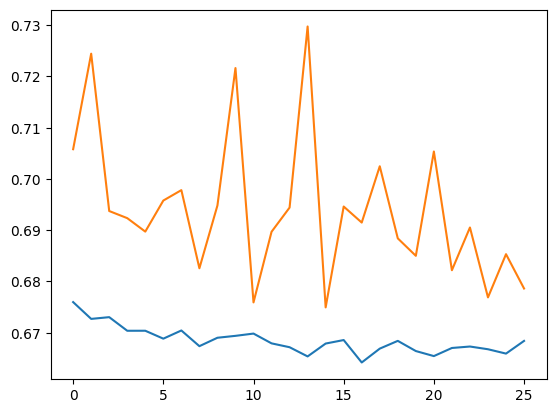

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [ ]:
model.load_state_dict(best_weights)
torch.save(model.state_dict(), '../trained_weights/sis_autoencoder2_fine.pt')